In [5]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import shutil

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", physical_devices, len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()
device_lib.list_local_devices()








Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16264554658844054846,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1788954624
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16241466717079585601
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [6]:
initial_lr = 1e-3 # learning rate
epochs = 30 # no of eopches to train
batch_size = 8 # batch size 
img_size = 150

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data"))
data = []
labels =[]

#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

#initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15, fill_mode="nearest")



print(labels[0])
print(labels[-1])

LOADING IMAGES.......
[1. 0.]
[0. 1.]


In [ ]:
## Below is for VGG16 net

In [7]:
#load VGG16 network
baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_size, img_size, 3)))
baseModel.trainable=False  # all base weight set to non-trainable
#constructing the head of the model that will be placed
#on the top of the model

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

#place the head FC model on top of the base model
#it will become the actual model will be train
model = Model(inputs=baseModel.input, outputs=headModel)

# #loop over all layers in the base model 
# for layer in baseModel.layers:
# 	layer.trainable = False

#compile our model
print("compileing model.....")
opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()



compileing model.....
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________

In [8]:
### no need run this cell to unfreeze model
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


model = unfreeze_model(model)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

tranning head.........
Epoch 1/30
80/80 [==============================] - 10s 38ms/step - loss: 5.2839 - accuracy: 0.7812 - val_loss: 2.2095 - val_accuracy: 0.8375
Epoch 2/30
80/80 [==============================] - 2s 26ms/step - loss: 1.2830 - accuracy: 0.8656 - val_loss: 2.3054 - val_accuracy: 0.7875
Epoch 3/30
80/80 [==============================] - 2s 26ms/step - loss: 0.6617 - accuracy: 0.8891 - val_loss: 0.8050 - val_accuracy: 0.8562
Epoch 4/30
80/80 [==============================] - 2s 25ms/step - loss: 0.4197 - accuracy: 0.9047 - val_loss: 0.5777 - val_accuracy: 0.8500
Epoch 5/30
80/80 [==============================] - 2s 27ms/step - loss: 0.2773 - accuracy: 0.9016 - val_loss: 0.3915 - val_accuracy: 0.8687
Epoch 6/30
80/80 [==============================] - 2s 26ms/step - loss: 0.2050 - accuracy: 0.9250 - val_loss: 0.4196 - val_accuracy: 0.8500
Epoch 7/30
80/80 [==============================] - 2s 25ms/step - loss: 0.2006 - accuracy: 0.9297 - val_loss: 0.3316 - val_accura

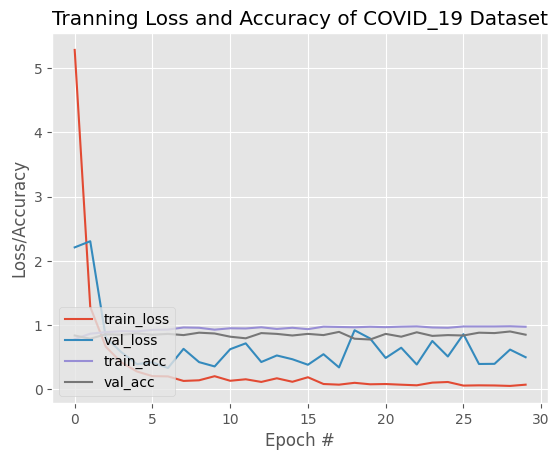

In [8]:
#train the head of the network
print("tranning head.........")
history = model.fit(
	trainAug.flow(trainX, trainY, batch_size= batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data = (testX, testY),
	validation_steps = len(testX) // batch_size,
	epochs = epochs)


# make predications on the testing set
print("evaluating network.....")
predIdxs = model.predict(testX, batch_size=batch_size)

# for each image in the testing set we need 
# to find the the index of the label with 
# corresponding largest predicated probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix nad use it 
# to drive the raw accuracy, sensitivity 
# and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total_test = sum(sum(cm))
accurancy = (cm[0, 0] + cm[1, 1]) / total_test	### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
sensitivity = cm[0, 0] / (cm[0, 0] + cm[1, 0])	### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1])	### Specificity (true negatives / all actual negatives) =TN / TN + FP

# show the cnfusion matrix, accuracy with 4 digits
#sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(accurancy))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the tranning loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")	
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")	
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")	
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Tranning Loss and Accuracy of COVID_19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## confusion matrix
## tp fp
## fn tn

### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
### Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
### Precision (true positives / predicted positives) = TP / TP + FP
### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
### Specificity (true negatives / all actual negatives) =TN / TN + FP
